# PaddlePaddle实现多层神经网络

欢迎大家来到这次实验，在这次实验中我们将使用PaddlePaddle来实现一个多层神经网络，这个多层神经网络包含2个隐藏层，并且在隐藏层中使用到了Relu激活函数，在最后的输出层使用了Softmax激活函数。多层神经网络具有比逻辑回归更强的学习能力，并且更适合解决多分类问题，现在让我们进入实验来看看多层神经网络与逻辑回归之间的差异性吧！

** 你将学会 **

- 实现一个具有两个隐藏层的神经网络，用于解决多分类问题

- 使用batch_norm做数据归一化

- 在隐藏层中使用Relu激活函数

- 在输出层使用Softmax激活函数

- 使用classification_cost

- 使用Adam作为优化器

现在让我们进入实验吧！

## 1 - 引用库

首先，载入几个需要用到的库，它们分别是：

- numpy：一个python的基本库，用于科学计算
- matplotlib.pyplot：用于生成图，在验证模型准确率和展示成本变化趋势时会使用到
- paddle.v2：PaddlePaddle深度学习框架
- os：在本例中用于获取文件或目录的路径
- csv：用于对csv文件的存储和读取等操作

In [1]:
import matplotlib
import numpy as np
import paddle.v2 as paddle

import matplotlib.pyplot as plt

import os
import csv

%matplotlib inline

** 问题描述： **

红酒的品种多样，质量也有高低之分，质量的好坏决定了红酒的价格定位，假设你被聘为一家红酒供应商的红酒质量鉴定专家，红酒供应商给你提供了一些红酒的指标值和评分数据，希望你能从这些数据中学习到红酒的质量鉴定方法。

** 你的目标： **

构建一个多层神经网络来对红酒质量评分

** 数据集分析： **

红酒数据集是采集于葡萄牙北部“Vinho Verde”葡萄酒的数据，它是研究Classification/Regression模型训练的经典数据集。这个数据集包含了红白两种葡萄酒的数据，在本实验中采用了红酒数据作为实验数据，红酒的数据包含11个特征值（指标）和一个0-10的评分值（由于隐私等问题，在特征值中不包含价格、品牌等因素，只涵盖了红酒的物理化学性质因素）：

输入值：

1 - fixed acidity 固定酸度

2 - volatile acidity 挥发性酸度

3 - citric acid 柠檬酸

4 - residual sugar 残糖

5 - chlorides 氯化物

6 - free sulfur dioxide 自由二氧化硫

7 - total sulfur dioxide 总二氧化硫

8 - density 密度

9 - pH pH值

10 - sulphates 硫酸盐

11 - alcohol 酒精

输出值：

12 - quality (0-10的评分) 质量

## 2 - 数据预处理

** 文件路径 **

红酒数据被存储在当前文件夹下的data目录中，data目录中共有两个数据文件，分别是：

- winequality-red.csv：红（葡萄）酒数据
- winequality-white.csv：白（葡萄）酒数据

我们暂时先使用数据量较少的红酒数据来训练模型，当然你可以在完成实验后，使用白（葡萄）酒数据来重新训练或者验证你的模型。

In [2]:
cur_dir = os.path.dirname(os.path.realpath("__file__"))

filename = cur_dir + "/data/winequality-red.csv"

** 载入数据 **

首先，我们使用csv.reader()来读取红酒数据，并存入data数组中，输出数据的属性和一组值。

In [3]:
with open(filename) as f:
        reader = csv.reader(f)
        data = []
        for row in reader:
            data.append([i for i in row[0].split(';')])        
            
print data[0],"\n"
print data[1]

['fixed acidity', '"volatile acidity"', '"citric acid"', '"residual sugar"', '"chlorides"', '"free sulfur dioxide"', '"total sulfur dioxide"', '"density"', '"pH"', '"sulphates"', '"alcohol"', '"quality"'] 

['7.4', '0.7', '0', '1.9', '0.076', '11', '34', '0.9978', '3.51', '0.56', '9.4', '5']


可以看到，数据中存储了关于红酒的11类特征值和1个标签值（分数）。

** 预处理 **

现在让我们对数据进行一些预处理操作。观察上面输出的数据样例，我们发现数据是以字符串的形式存储的，并且第一行数据（data[0]）存储的是属性，而不是具体的数据，所以我们需要去除第一行数据，并且将剩余的数据类型转换为np.float32的numpy数组。这一操作十分简单，只需要使用np.array(<font color=blue>array</font>).astype(<font color=blue>type</font>)即可完成。

** 练习： **

取出除第一行外的数据，并将数据类型转换为np.float32的numpy数组。

In [4]:
data = np.array(data[1:]).astype(np.float32)

print data[0]

[  7.4000001    0.69999999   0.           1.89999998   0.076       11.          34.
   0.99779999   3.50999999   0.56         9.39999962   5.        ]


** 期望输出： **
<table>
<tr>
<td>
[  7.4000001    0.69999999   0.           1.89999998   0.076       11.          34.
   0.99779999   3.50999999   0.56         9.39999962   5.        ]
</td>
</tr>
</table>

想要训练一个模型，我们首先需要将原始数据集切分为训练数据集(train set)和训练数据集(test set)，定义一个$ratio$变量，它是一个介于$[0,1]$区间的标量，代表着训练数据占总数据的比重，例如设置$ratio=0.8$，它表示训练数据占总数据量的八成，如果data_num代表数据总数，那么ratio * data_num等于训练集数量。

** 练习： **

将数据划分为训练数据集和测试数据集（因为数据量较少，建议将ratio设置为0.8左右较为合理）

In [5]:
ratio = 0.8
data_num = len(data)
slice = int(ratio * data_num)
train_set = data[:slice]
test_set = data[slice:]

print "train set shape:", train_set.shape
print "test set shape:", test_set.shape

train set shape: (1279, 12)
test set shape: (320, 12)


如果将ratio设置为0.8则

** 期望输出： **

<table style="width:20%">
    <tr>
        <td>
            ** train set shape ** 
        </td>
        <td>
            (1278, 12)
        </td>
    </tr>
    <tr>
        <td>
            ** test set shape ** 
        </td>
        <td>
            (320, 12)
        </td>
    </tr>
</table>


## 3 - 构造reader

在逻辑回归的实验中我们介绍了reader()的构造方法以及生成器的概念，在这里我们同样构造一个read_data()函数来读取训练数据集train_set或者测试数据集test_set。它的具体实现是在read_data()函数内部构造一个reader()，使用yield关键字来让reader()成为一个Generator（生成器）。

** 注意：** 由于红酒的品质鉴定属于多分类问题（将结果划分为0-10的离散整数），所以我们将标签值（评分）的数据类型转化为integer类型。

In [6]:
def read_data(data):
    def reader():
        for d in data:
            yield d[:-1], int(d[-1])
    return reader

test_arr = [[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,1],
            [0,0,0,0,0,0,0,0,0,0,0,0]
            ]

reader = read_data(test_arr)
for d in reader():
    print d 

([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 1)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0)


** 期望输出： **

<table style="width:30%;text-align:center" >
    <tr>
        <td>
            ([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 1)
            ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0)
        </td>
    </tr>
</table>



## 4 - 训练过程

完成了数据的预处理工作并构造了read_data()来读取数据，接下来将进入模型的训练过程，使用PaddlePaddle来构造可训练的Logistic回归模型，关键步骤如下：

- 初始化

- 配置网络结构和设置参数
    - 配置网络结构
    - 定义损失函数cost
    - 创建parameters
    - 定义优化器optimizer

- 模型训练

- 模型检验

- 预测

- 绘制学习曲线

** （1）初始化 **

首先进行最基本的初始化操作，在PaddlePaddle中使用paddle.init(use_gpu=False, trainer_count=1)来进行初始化：

- use_gpu=False表示不使用gpu进行训练

- trainer_count=1表示仅使用一个训练器进行训练

In [7]:
# 初始化
paddle.init(trainer_count=1, use_gpu=False)

** （2）配置网络结构和设置参数 **

** 网络结构： **

了解一下我们即将要配置的网络结构，如图所示，它的基本结构是输入层、两个隐藏层和输出层，两个隐藏层使用ReLU激活函数，输出层使用Softmax激活函数（多分类），除此之外，在输入层之后添加一层Batch Normalization对数据进行归一化处理。

<img src="image/structure.png" width="500px">

下面我们简单介绍一下网络结构中使用到的ReLU以及Softmax激活函数：

** ReLU(Rectified linear unit) **

ReLU激活函数通常比sigmoid和tanh激活函数的表现更好，其中一个原因是sigmoid和tanh在两端的饱和阶段梯度接近0，容易造成梯度消失问题(Vanishing Gradient Problem)，尤其是在深度网络中更加明显，而ReLU在非负区间的梯度为常数，因此不存在梯度消失问题，使得模型的收敛速度维持在一个稳定状态。我们在两个隐藏层上使用ReLU作为激活函数。

<img src="image/relu.png" width="200px">

** Softmax **

Softmax是神经网络中另一种激活函数，计算输出层的值。主要用于神经网络最后一层，作为输出层进行多分类，是逻辑回归二分类的推广。

Sigmoid将结果值映射到$[0,1]$区间，用来做二分类。 而Softmax的函数形式如下，把一个k维的向量（y1,y2,y3,y4 … yk.）映射成（a1,a2,a3 … ak.），其中ai介于区间$[0,1]$，根据ai的大小来进行多分类的任务，如取权重最大的一维。

<img src="image/softmax.png" width="250px">


** 配置网络结构 **

现在我们已经了解了网络结构，开始着手配置吧！

** 练习：** 使用PaddlePaddle配置网络结构

** 输入层： **

我们可以定义x=paddle.layer.data(name=”x”, type=paddle.data_type.dense_vector(data_dim))来表示生成一个数据输入层，名称为“x”，数据类型为data_dim维向量；

在定义输入层之前，我们需要计算数据的特征维度data_dim。

** Batch normalization层： **

我们可以定义norm1 = paddle.layer.batch_norm(input=x, act=paddle.activation.Relu())表示生成一个Batch normalization层，输入数据为x，激活函数为Relu()；

** 隐藏层： **

我们定义两个隐藏层h1和h2，以h1为例，定义h1=paddle.layer.fc(input=norm1, size=32, act=paddle.activation.Relu())，表示生成一个全连接层类型的隐藏层，输入数据为norm1，神经元个数为32，激活函数为Relu()；

** 输出层： **

我们可以定义predict=paddle.layer.fc(input=h2, size=10, act=paddle.activation.Softmax())表示生成一个全连接层，输入数据为h2，输出结果共有10个，分别表示十个不同的分类，激活函数为Softmax()；

** 标签层 **

我们可以定义label = paddle.layer.data(name='label', type=paddle.data_type.integer_value(10))表示生成一个数据层，名称为“label”，数据类型为包含0-9的整型。

In [8]:
data_dim = train_set.shape[1] - 1

x = paddle.layer.data(name='x', type=paddle.data_type.dense_vector(data_dim))

norm1 = paddle.layer.batch_norm(input=x, act=paddle.activation.Relu())

h1 = paddle.layer.fc(input=norm1, size=32, act=paddle.activation.Relu())

h2 = paddle.layer.fc(input=h1, size=16, act=paddle.activation.Relu())

predict = paddle.layer.fc(input=h2, size=10, act=paddle.activation.Softmax())

label = paddle.layer.data(name='label', type=paddle.data_type.integer_value(10))

** 定义损失函数 **

在配置网络结构之后，我们需要定义一个损失函数来计算梯度并优化参数，在这里我们可以使用PaddlePaddle提供的用于多分类的损失函数，定义cost = paddle.layer.classification_cost(input=predict, label=label)，使用predict与label计算成本。

** 练习： **

定义多分类损失函数

In [9]:
# 损失函数
### START CODE HERE ### (≈ 2 lines of code)
cost = paddle.layer.classification_cost(input=predict, label=label)
### END CODE HERE ###

** 创建parameters **

PaddlePaddle中提供了接口paddle.parameters.create(cost)来创建和初始化参数，参数cost表示基于我们刚刚创建的cost损失函数来创建和初始化参数。

In [10]:
# 创建parameters
### START CODE HERE ### (≈ 1 lines of code)
parameters = paddle.parameters.create(cost)
### END CODE HERE ###

** optimizer **

参数创建完成后，我们需要定义一个优化器optimizer，在逻辑回归实验中我们使用了Momentum作为优化器，在这里我们尝试使用Adam来作为优化器，它的计算公式如下：

$$\begin{split}m(w, t) & = \beta_1 m(w, t-1) + (1 - \beta_1) \nabla Q_i(w) \\ v(w, t) & = \beta_2 v(w, t-1) + (1 - \beta_2)(\nabla Q_i(w)) ^2 \\ w & = w - \frac{\eta m(w, t)}{\sqrt{v(w,t) + \epsilon}}\end{split}$$

Adam是一种常用的、效果良好的自适应学习率调整优化算法，通常只需要将参数设置为beta1=0.9，beta2=0.999，epsilon=1e-08，不需要作修改即可让模型产生好的收敛效果。在PaddlePaddle中可以使用接口paddle.optimizer.Adam()来创建Adam优化器。

** 练习： **

创建Adam优化器

In [11]:
#创建optimizer

optimizer = paddle.optimizer.Adam(
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-08
)

** 其它配置 **

feeding={‘x’:0, ‘label’:1}是数据层名称和数组索引的映射，用于在训练时输入数据，lists数组用于保存pass_id, train set cost, test set cost等信息。

最后定义函数event_handler(event)用于事件处理，设置每100次迭代，利用测试数据来计算当前的test set cost，并将pass_id，train set cost和test set cost输出并存储至lists中。

In [77]:
feeding = {
    'x': 0,
    'label': 1
}

lists = []

def event_handler(event):
    if isinstance(event, paddle.event.EndIteration):
        if event.pass_id % 100 == 0 and event.batch_id == 0:
            result = trainer.test(reader=paddle.batch(
                read_data(test_set), batch_size=128))
            print("pass {}, batch_id {}, train set cost {}, test set cost {}").format(event.pass_id, event.batch_id, event.cost, result.cost)
            lists.append((event.pass_id, event.cost, result.cost))

** 模型训练 **

在逻辑回归实验中我们介绍了trainer的构建以及训练过程的参数配置，相信大家已经理解并学会如何配置buf_size/batch_size/num_passes等参数。

** 练习：**

定义trainer并开始训练模型

In [78]:
trainer = paddle.trainer.SGD(
    cost=cost, parameters=parameters, update_equation=optimizer
)

trainer.train(
    reader=paddle.batch(
        paddle.reader.shuffle(read_data(train_set), buf_size=5000),
        batch_size=128
    ),
    feeding=feeding,
    event_handler=event_handler,
    num_passes=1000
)

pass 0, batch_id 0, train set cost 2.281031847, test set cost 8.64661445618
pass 100, batch_id 0, train set cost 0.864398658276, test set cost 1.02421370745
pass 200, batch_id 0, train set cost 0.777176737785, test set cost 1.04286775589
pass 300, batch_id 0, train set cost 0.739849030972, test set cost 1.07083622217
pass 400, batch_id 0, train set cost 0.579931437969, test set cost 1.12942759991
pass 500, batch_id 0, train set cost 0.834986150265, test set cost 1.17374812365
pass 600, batch_id 0, train set cost 0.66029715538, test set cost 1.21673964262
pass 700, batch_id 0, train set cost 0.630392193794, test set cost 1.25913171768
pass 800, batch_id 0, train set cost 0.664287745953, test set cost 1.31677081585
pass 900, batch_id 0, train set cost 0.623641610146, test set cost 1.38956637383


In [79]:
# 查看训练过程中的最佳pass
best = sorted(lists, key=lambda list: float(list[2]))[0]
print("Best pass is {}, training Avgcost is {}, testing Avgcost is {}").format(best[0], best[1], best[2])

Best pass is 100, training Avgcost is 0.864398658276, testing Avgcost is 1.02421370745


** 模型检验 **

模型训练完成后，接下来检验模型的准确率。

利用paddle.infer()来进行预测，参数output_layer表示输出层，参数parameters表示模型参数，参数input表示输入的测试数据。

** 练习：**

- 使用paddle.infer()进行预测

- 输出部分红酒的label和预测评分进行对比

** 技巧： **

预测结果probs是（num_test, 10）的numpy数组，每个测试样例的输出结果为10个数字，分别代表红酒的评分是0-9的可能性，我们取出可能性最大的值作为最后的评分，所以我们可以使用lab=np.argsort(-probs)来做降序排序，将可能性最大的评分放在最前头，这样lab[i][0]则表示第i瓶红酒的最终评分。

In [80]:
data_creater = read_data(test_set)

test_x = []
test_y = []
for item in data_creater():
    test_x.append((item[0], ))
    test_y.append(item[1])

probs = paddle.infer(
        output_layer=predict, parameters=parameters, input=test_x)

print "probs shape:", probs.shape
print "probs sample:", probs[0]

probs shape: (320, 10)
probs sample: [  3.59487516e-04   1.54166482e-04   3.75506788e-04   2.31721625e-03
   7.76880002e-03   9.91239324e-02   6.52422309e-01   1.98356614e-01
   3.81874442e-02   9.34517360e-04]


In [81]:
lab = np.argsort(-probs)

for i in range(20):
    print("label: {}, predict: {}").format(lab[i][0], test_y[i])

label: 6, predict: 7
label: 6, predict: 6
label: 6, predict: 6
label: 6, predict: 6
label: 5, predict: 6
label: 6, predict: 5
label: 6, predict: 5
label: 6, predict: 6
label: 6, predict: 5
label: 5, predict: 5
label: 5, predict: 5
label: 6, predict: 5
label: 6, predict: 6
label: 7, predict: 6
label: 5, predict: 4
label: 6, predict: 6
label: 5, predict: 5
label: 5, predict: 5
label: 6, predict: 6
label: 6, predict: 6


我们输出了20瓶红酒的label和predict值，可以看到模型对红酒数据的学习效果还算不错，现在可以为红酒供应商进行大批量的红酒质量鉴定工作了。恭喜你完成了更加复杂的深度学习实验，同样，你可以参考官方[PaddlePaddle文档](http://paddlepaddle.org/docs/develop/documentation/zh/getstarted/index_cn.html)来修改模型，尝试得到更好的结果。

** 学习曲线 **

接下来我们利用之前保存的lists数据来输出成本的变化情况，利用学习曲线对模型进行分析。

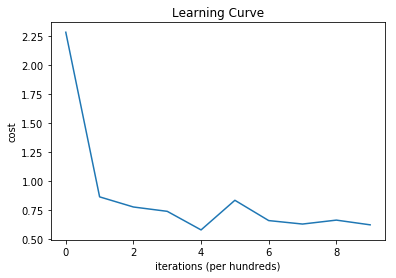

In [83]:
costs = np.squeeze([list[1] for list in lists])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning Curve")
plt.show()

我们可以看到，模型在最初收敛很快，但在学习后期出现波动，但总体为下降趋势，这可能是因为Adam的缺点，即在训练后期引起学习率的震荡，导致模型无法收敛，通常我们可以在训练后期改用SGD来训练以达到更好的效果。

# 5 - 总结

通过这个练习我们应该记住：

1. ReLU激活函数比tanh和sigmoid更适合深层神经网络，因为它不存在梯度消失问题

2. 使用Batch Normalization能够加速模型训练

3. 利用Softmax可以解决多分类问题

4. Adam是一种常用的、效果良好的自适应学习率调整优化算法，通常使用它能够得到不错的学习效果。


至此，我们完成了比逻辑回归模型稍复杂的多层神经网络模型的配置和训练，不难发现，在PaddlePaddle中，只需要通过简单地叠加或删除数据层、连接层等，就可以轻易地改变模型结构，自由度很高，大家可以尝试使用更多层数的神经网络或者改变每一层的神经元个数来修改模型，在调试中加深对深度学习的理解和PaddlePaddle框架的熟悉度。